In [ ]:
import os
project_name = "reco-chef"; branch = "30music"; account = "sparsh-ai"
project_path = os.path.join('/content', project_name)

In [ ]:
if not os.path.exists(project_path):
    !pip install -U -q dvc dvc[gdrive]
    !cp -r /content/drive/MyDrive/git_credentials/. ~
    path = "/content/" + project_name; 
    !mkdir "{path}"
    %cd "{path}"
    !git init
    !git remote add origin https://github.com/"{account}"/"{project_name}".git
    !git pull origin "{branch}"
    !git checkout "{branch}"
else:
    %cd "{project_path}"

/content/reco-chef


In [ ]:
!git status

On branch 30music
Your branch is up to date with 'origin/30music'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   src/eval/seqeval.py
	modified:   src/models/itempop.py
	modified:   src/train/itempop.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	artifacts/30music/
	src/eval/itempop.py

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git add . && git commit -m 'commit' && git push origin "{branch}"

usic d6ec8d0] commit
 6 files changed, 54 insertions(+), 19 deletions(-)
 create mode 100644 artifacts/30music/models/itempop.pkl
 create mode 100644 artifacts/30music/results/itempop.pkl
 create mode 100644 src/eval/itempop.py
Counting objects: 16, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (14/14), done.
Writing objects: 100% (16/16), 11.72 KiB | 3.91 MiB/s, done.
Total 16 (delta 6), reused 0 (delta 0)
remote: Resolving deltas: 100% (6/6), completed with 6 local objects.
To https://github.com/sparsh-ai/reco-chef.git
   5ed111a..d6ec8d0  30music -> 30music


In [ ]:
!dvc status

In [ ]:
!pip install -U -e .

Obtaining file:///content/reco-chef
  Attempting uninstall: recotut
    Found existing installation: recotut 0.0.1
    Can't uninstall 'recotut'. No files were found to uninstall.
  Running setup.py develop for recotut


In [ ]:
!make setup

pip install -e .
Obtaining file:///content/reco-chef
  Attempting uninstall: recotut
    Found existing installation: recotut 0.0.1
    Can't uninstall 'recotut'. No files were found to uninstall.
  Running setup.py develop for recotut


In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
!dvc pull ./data/bronze/30music/sessions_sample_10.parquet.snappy.dvc

In [ ]:
!dvc repro

## Prototyping

In [ ]:
import operator
import logging
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

### Abstract recommender class

In [ ]:
class ISeqRecommender(object):
    """Abstract Recommender class"""

    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger()

    def __init__(self):
        super(ISeqRecommender, self).__init__()

    def fit(self, train_data):
        pass

    def recommend(self, user_profile, user_id=None):
        """
        Given the user profile return a list of recommendation
        :param user_profile: the user profile as a list of item identifiers
        :param user_id: (optional) the user id
        :return: list of recommendations e.g. [([2], 0.875), ([6], 1.0)]
        """
        pass

    @staticmethod
    def get_recommendation_list(recommendation):
        return list(map(lambda x: x[0], recommendation))

    @staticmethod
    def get_recommendation_confidence_list(recommendation):
        return list(map(lambda x: x[1], recommendation))

    def activate_debug_print(self):
        self.logger.setLevel(logging.DEBUG)

    def deactivate_debug_print(self):
        self.logger.setLevel(logging.INFO)

### Evaluation metrics

In [ ]:
class EvalMetrics:
    def __init__(self):
        pass

    def precision(self, ground_truth, prediction):
        """
        Compute Precision metric
        :param ground_truth: the ground truth set or sequence
        :param prediction: the predicted set or sequence
        :return: the value of the metric
        """
        ground_truth = self._remove_duplicates(ground_truth)
        prediction = self._remove_duplicates(prediction)
        precision_score = self._count_a_in_b_unique(prediction, ground_truth) / float(len(prediction))
        assert 0 <= precision_score <= 1
        return precision_score

    def recall(self, ground_truth, prediction):
        """
        Compute Recall metric
        :param ground_truth: the ground truth set or sequence
        :param prediction: the predicted set or sequence
        :return: the value of the metric
        """
        ground_truth = self._remove_duplicates(ground_truth)
        prediction = self._remove_duplicates(prediction)
        recall_score = 0 if len(prediction) == 0 else self._count_a_in_b_unique(prediction, ground_truth) / float(
            len(ground_truth))
        assert 0 <= recall_score <= 1
        return recall_score

    def mrr(self, ground_truth, prediction):
        """
        Compute Mean Reciprocal Rank metric. Reciprocal Rank is set 0 if no predicted item is in contained the ground truth.
        :param ground_truth: the ground truth set or sequence
        :param prediction: the predicted set or sequence
        :return: the value of the metric
        """
        rr = 0.
        for rank, p in enumerate(prediction):
            if p in ground_truth:
                rr = 1. / (rank + 1)
                break
        return rr

    @staticmethod
    def _count_a_in_b_unique(a, b):
        """
        :param a: list of lists
        :param b: list of lists
        :return: number of elements of a in b
        """
        count = 0
        for el in a:
            if el in b:
                count += 1
        return count

    @staticmethod
    def _remove_duplicates(l):
        return [list(x) for x in set(tuple(x) for x in l)]

In [ ]:
gt = [(1,1),(0,1)]
pd = [(1,0),(0,1)]

ev = EvalMetrics()
ev.precision(gt,pd), ev.recall(gt,pd), ev.mrr(gt,pd)

(0.5, 0.5, 0.5)

### Sequential evaluator methods

In [ ]:
class SequentialEvaluator:
    """
    In the evaluation of sequence-aware recommenders, each sequence in the test set is split into:
    - the user profile, used to compute recommendations, is composed by the first k events in the sequence;
    - the ground truth, used for performance evaluation, is composed by the remainder of the sequence.
    
    you can control the dimension of the user profile by assigning a positive value to GIVEN_K,
    which correspond to the number of events from the beginning of the sequence that will be assigned
    to the initial user profile. This ensures that each user profile in the test set will have exactly
    the same initial size, but the size of the ground truth will change for every sequence.

    Alternatively, by assigning a negative value to GIVEN_K, you will set the initial size of the ground truth.
    In this way the ground truth will have the same size for all sequences, but the dimension of the user
    profile will differ.
    """

    def __init__(self, train_data, test_data, recommender):
        self.test_data = test_data
        self.recommender = recommender
        self.train_users = train_data['user_id'].values
        self.evalmetrics = EvalMetrics()
        self.evaluation_functions = {'precision':self.evalmetrics.precision,
                        'recall':self.evalmetrics.recall,
                        'mrr': self.evalmetrics.mrr}

    def get_test_sequences(self, given_k):
        # we can run evaluation only over sequences longer than abs(LAST_K)
        test_sequences = self.test_data.loc[self.test_data['sequence'].map(len) > abs(given_k), 'sequence'].values
        return test_sequences

    def get_test_sequences_and_users(self, given_k):
        # we can run evaluation only over sequences longer than abs(LAST_K)
        mask = self.test_data['sequence'].map(len) > abs(given_k)
        mask &= self.test_data['user_id'].isin(self.train_users)
        test_sequences = self.test_data.loc[mask, 'sequence'].values
        test_users = self.test_data.loc[mask, 'user_id'].values
        return test_sequences, test_users

    def sequential_evaluation(self, test_sequences, users=None, given_k=1,
                              look_ahead=1, top_n=10, scroll=True, step=1):
        """
        Runs sequential evaluation of a recommender over a set of test sequences
        :param recommender: the instance of the recommender to test
        :param test_sequences: the set of test sequences
        :param evaluation_functions: list of evaluation metric functions
        :param users: (optional) the list of user ids associated to each test sequence. Required by personalized models like FPMC.
        :param given_k: (optional) the initial size of each user profile, starting from the first interaction in the sequence.
                        If <0, start counting from the end of the sequence. It must be != 0.
        :param look_ahead: (optional) number of subsequent interactions in the sequence to be considered as ground truth.
                        It can be any positive number or 'all' to extend the ground truth until the end of the sequence.
        :param top_n: (optional) size of the recommendation list
        :param scroll: (optional) whether to scroll the ground truth until the end of the sequence.
                    If True, expand the user profile and move the ground truth forward of `step` interactions. Recompute and evaluate recommendations every time.
                    If False, evaluate recommendations once per sequence without expanding the user profile.
        :param step: (optional) number of interactions that will be added to the user profile at each step of the sequential evaluation.
        :return: the list of the average values for each evaluation metric
        """
        if given_k == 0:
            raise ValueError('given_k must be != 0')

        evaluation_functions = self.evaluation_functions.values()

        metrics = np.zeros(len(evaluation_functions))
        with tqdm(total=len(test_sequences)) as pbar:
            for i, test_seq in enumerate(test_sequences):
                if users is not None:
                    user = users[i]
                else:
                    user = None
                if scroll:
                    metrics += self.sequence_sequential_evaluation(test_seq,
                                                                   user,
                                                                   given_k,
                                                                   look_ahead,
                                                                   top_n,
                                                                   step)
                else:
                    metrics += self.evaluate_sequence(test_seq, 
                                                      user,
                                                      given_k,
                                                      look_ahead,
                                                      top_n)
                pbar.update(1)

        return metrics / len(test_sequences)

    def evaluate_sequence(self, seq, user, given_k, look_ahead, top_n):
        """
        :param recommender: which recommender to use
        :param seq: the user_profile/ context
        :param given_k: last element used as ground truth. NB if <0 it is interpreted as first elements to keep
        :param evaluation_functions: which function to use to evaluate the rec performance
        :param look_ahead: number of elements in ground truth to consider. if look_ahead = 'all' then all the ground_truth sequence is considered
        :return: performance of recommender
        """
        # safety checks
        if given_k < 0:
            given_k = len(seq) + given_k

        user_profile = seq[:given_k]
        ground_truth = seq[given_k:]

        # restrict ground truth to look_ahead
        ground_truth = ground_truth[:look_ahead] if look_ahead != 'all' else ground_truth
        ground_truth = list(map(lambda x: [x], ground_truth))  # list of list format

        user_profile = list(user_profile)
        ground_truth = list(ground_truth)
        evaluation_functions = self.evaluation_functions.values()

        if not user_profile or not ground_truth:
            # if any of the two missing all evaluation functions are 0
            return np.zeros(len(evaluation_functions))

        r = self.recommender.recommend(user_profile, user)[:top_n]

        if not r:
            # no recommendation found
            return np.zeros(len(evaluation_functions))
        reco_list = self.recommender.get_recommendation_list(r)

        tmp_results = []
        for f in evaluation_functions:
            tmp_results.append(f(ground_truth, reco_list))
        return np.array(tmp_results)

    def sequence_sequential_evaluation(self, seq, user, given_k, look_ahead, top_n, step):
        if given_k < 0:
            given_k = len(seq) + given_k

        eval_res = 0.0
        eval_cnt = 0
        for gk in range(given_k, len(seq), step):
            eval_res += self.evaluate_sequence(seq,
                                                user,
                                                gk,
                                                look_ahead,
                                                top_n)
            eval_cnt += 1
        return eval_res / eval_cnt

    def eval_seqreveal(self, user_flg=0, GIVEN_K=1, LOOK_AHEAD=1, STEP=1, TOPN=20):
        if user_flg:
            test_sequences, test_users = self.get_test_sequences_and_users(GIVEN_K)
            print('{} sequences available for evaluation ({} users)'.format(len(test_sequences), len(np.unique(test_users))))
            results = self.sequential_evaluation(test_sequences,
                                                users=test_users,
                                                given_k=GIVEN_K,
                                                look_ahead=LOOK_AHEAD,
                                                top_n=TOPN,
                                                scroll=True,  # scrolling averages metrics over all profile lengths
                                                step=STEP)
        else:
            test_sequences = self.get_test_sequences(GIVEN_K)
            print('{} sequences available for evaluation'.format(len(test_sequences)))
            results = self.sequential_evaluation(test_sequences,
                                                given_k=GIVEN_K,
                                                look_ahead=LOOK_AHEAD,
                                                top_n=TOPN,
                                                scroll=True,  # scrolling averages metrics over all profile lengths
                                                step=STEP)
        
        # print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
        # for mname, mvalue in zip(self.evaluation_functions.keys(), results):
        #     print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))
        return [results, GIVEN_K, LOOK_AHEAD, STEP]  


    def eval_staticprofile(self, user_flg=0, GIVEN_K=1, LOOK_AHEAD='all', STEP=1, TOPN=20):
        if user_flg:
            test_sequences, test_users = self.get_test_sequences_and_users(GIVEN_K) # we need user ids now!
            print('{} sequences available for evaluation ({} users)'.format(len(test_sequences), len(np.unique(test_users))))
            results = self.sequential_evaluation(test_sequences,
                                                users=test_users,
                                                given_k=GIVEN_K,
                                                look_ahead=LOOK_AHEAD,
                                                top_n=TOPN,
                                                scroll=False  # notice that scrolling is disabled!
                                            )                                
        else:
            test_sequences = self.get_test_sequences(GIVEN_K)
            print('{} sequences available for evaluation'.format(len(test_sequences)))
            results = self.sequential_evaluation(test_sequences,
                                                 given_k=GIVEN_K,
                                                 look_ahead=LOOK_AHEAD,
                                                 top_n=TOPN,
                                                 scroll=False  # notice that scrolling is disabled!
                                                 )
            
        return [results, GIVEN_K, LOOK_AHEAD, STEP] 

    def eval_reclength(self, user_flg=0, GIVEN_K=1, LOOK_AHEAD=1, STEP=1,
                       topn_list=[1,5,10,20,50,100], TOPN=20):
        res_list = []

        if user_flg:
            test_sequences, test_users = self.get_test_sequences_and_users(GIVEN_K) # we need user ids now!
            print('{} sequences available for evaluation ({} users)'.format(len(test_sequences), len(np.unique(test_users))))
            for topn in topn_list:
                print('Evaluating recommendation lists with length: {}'.format(topn)) 
                res_tmp = self.sequential_evaluation(test_sequences,
                                                        users=test_users,
                                                        given_k=GIVEN_K,
                                                        look_ahead=LOOK_AHEAD,
                                                        top_n=topn,
                                                        scroll=True,  # here we average over all profile lengths
                                                        step=STEP
                                                )
                mvalues = list(zip(self.evaluation_functions.keys(), res_tmp))
                res_list.append((topn, mvalues))                            
        else:
            test_sequences = self.get_test_sequences(GIVEN_K)
            print('{} sequences available for evaluation'.format(len(test_sequences)))
            for topn in topn_list:
                print('Evaluating recommendation lists with length: {}'.format(topn))      
                res_tmp = self.sequential_evaluation(test_sequences,
                                                    given_k=GIVEN_K,
                                                    look_ahead=LOOK_AHEAD,
                                                    top_n=topn,
                                                    scroll=True,  # here we average over all profile lengths
                                                    step=STEP)
                mvalues = list(zip(self.evaluation_functions.keys(), res_tmp))
                res_list.append((topn, mvalues))

        # show separate plots per metric
        # fig, axes = plt.subplots(nrows=1, ncols=len(self.evaluation_functions), figsize=(15,5))
        res_list_t = list(zip(*res_list))
        results = []
        for midx, metric in enumerate(self.evaluation_functions):
            mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
            fig, ax = plt.subplots(figsize=(5,5))
            ax.plot(topn_list, mvalues)
            ax.set_title(metric)
            ax.set_xticks(topn_list)
            ax.set_xlabel('List length')
            fig.tight_layout()
            results.append(fig)
        return [results, GIVEN_K, LOOK_AHEAD, STEP]

    def eval_profilelength(self, user_flg=0, given_k_list=[1,2,3,4], 
                           LOOK_AHEAD=1, STEP=1, TOPN=20):
        res_list = []

        if user_flg:
            test_sequences, test_users = self.get_test_sequences_and_users(max(given_k_list)) # we need user ids now!
            print('{} sequences available for evaluation ({} users)'.format(len(test_sequences), len(np.unique(test_users))))
            for gk in given_k_list:
                print('Evaluating profiles having length: {}'.format(gk))
                res_tmp = self.sequential_evaluation(test_sequences,
                                                            users=test_users,
                                                            given_k=gk,
                                                            look_ahead=LOOK_AHEAD,
                                                            top_n=TOPN,
                                                            scroll=False,  # here we stop at each profile length
                                                            step=STEP)
                mvalues = list(zip(self.evaluation_functions.keys(), res_tmp))
                res_list.append((gk, mvalues))                          
        else:
            test_sequences = self.get_test_sequences(max(given_k_list))
            print('{} sequences available for evaluation'.format(len(test_sequences)))
            for gk in given_k_list:
                print('Evaluating profiles having length: {}'.format(gk))
                res_tmp = self.sequential_evaluation(test_sequences,
                                                            given_k=gk,
                                                            look_ahead=LOOK_AHEAD,
                                                            top_n=TOPN,
                                                            scroll=False,  # here we stop at each profile length
                                                            step=STEP)
                mvalues = list(zip(self.evaluation_functions.keys(), res_tmp))
                res_list.append((gk, mvalues))

        # show separate plots per metric
        # fig, axes = plt.subplots(nrows=1, ncols=len(self.evaluation_functions), figsize=(15,5))
        res_list_t = list(zip(*res_list))
        results = []
        for midx, metric in enumerate(self.evaluation_functions):
            mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
            fig, ax = plt.subplots(figsize=(5,5))
            ax.plot(given_k_list, mvalues)
            ax.set_title(metric)
            ax.set_xticks(given_k_list)
            ax.set_xlabel('Profile length')
            fig.tight_layout()
            results.append(fig)
        return [results, TOPN, LOOK_AHEAD, STEP]

### Item Popularity Model

In [ ]:
class PopularityRecommender(ISeqRecommender):

    def __init__(self):
        super(PopularityRecommender, self).__init__()

    def fit(self, train_data):
        sequences = train_data['sequence'].values

        count_dict = {}
        for s in sequences:
            for item in s:
                if item not in count_dict:
                    count_dict[item] = 1
                else:
                    count_dict[item] += 1

        self.top = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=True)
        self.top = [([x[0]], x[1]) for x in self.top]

    def recommend(self, user_profile, user_id=None):
        return self.top

    def get_popular_list(self):
        return self.top

### Run

In [ ]:
METRICS = {'precision':precision, 
           'recall':recall,
           'mrr': mrr}
TOPN=100 # length of the recommendation list

In [ ]:
import os
import pandas as pd

base_path = './data/silver/30music'

train_data = pd.read_parquet(os.path.join(base_path, 'train.parquet.snappy'))
test_data = pd.read_parquet(os.path.join(base_path, 'test.parquet.snappy'))

train_data.head()

session_id                 sequence          ts  user_id
0          357              [793, 3489]  1421003874     4296
9         9795                   [1719]  1420700645     5612
10        9796       [1065, 3812, 4012]  1420713509     5612
11        9797                [532, 93]  1420724661     5612
12        9798  [6932, 3437, 1829, 335]  1420728275     5612

In [ ]:
train_data.shape[0], test_data.shape[0]

(2600, 4165)

In [ ]:
pop_recommender = PopularityRecommender()

In [ ]:
pop_recommender.fit(train_data)

In [ ]:
pop_recommender.recommend(user_profile=[1719])[:5]

[(['443'], 91), (['1065'], 66), (['658'], 65), (['67'], 60), (['1622'], 60)]

In [ ]:
evaluator = SequentialEvaluator(train_data, test_data, pop_recommender)

In [ ]:
evaluator.eval_seqreveal()

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:01<00:00, 1593.56it/s]


[array([0.00175849, 0.17584869, 0.01508671]), 1, 1, 1]

In [ ]:
evaluator.eval_staticprofile()

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:00<00:00, 5794.49it/s]


[array([0.00836735, 0.17499766, 0.05131012]), 1, 'all', 1]

2891 sequences available for evaluation
Evaluating recommendation lists with length: 1


100%|██████████| 2891/2891 [00:00<00:00, 11964.37it/s]


Evaluating recommendation lists with length: 5


100%|██████████| 2891/2891 [00:00<00:00, 9321.66it/s]


Evaluating recommendation lists with length: 10


100%|██████████| 2891/2891 [00:00<00:00, 7501.51it/s]


Evaluating recommendation lists with length: 20


100%|██████████| 2891/2891 [00:00<00:00, 5139.25it/s]


Evaluating recommendation lists with length: 50


100%|██████████| 2891/2891 [00:01<00:00, 2837.15it/s]


Evaluating recommendation lists with length: 100


100%|██████████| 2891/2891 [00:01<00:00, 1616.13it/s]


[[<Figure size 360x360 with 1 Axes>,
  <Figure size 360x360 with 1 Axes>,
  <Figure size 360x360 with 1 Axes>],
 1,
 1,
 1]

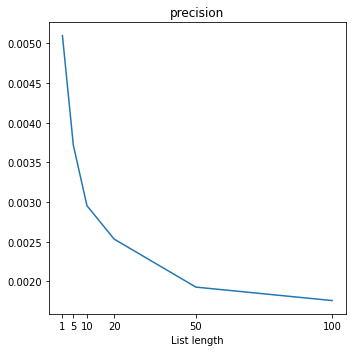

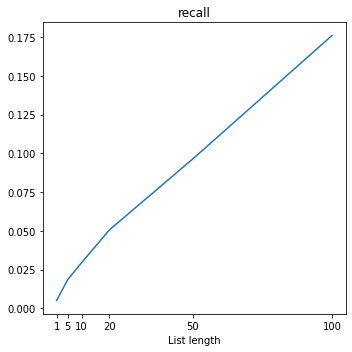

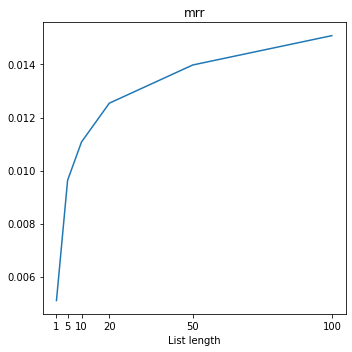

In [ ]:
evaluator.eval_reclength()

1164 sequences available for evaluation
Evaluating profiles having length: 1


100%|██████████| 1164/1164 [00:00<00:00, 20230.60it/s]


Evaluating profiles having length: 2


100%|██████████| 1164/1164 [00:00<00:00, 22951.91it/s]


Evaluating profiles having length: 3


100%|██████████| 1164/1164 [00:00<00:00, 21616.29it/s]


Evaluating profiles having length: 4


100%|██████████| 1164/1164 [00:00<00:00, 23391.56it/s]


[[<Figure size 360x360 with 1 Axes>,
  <Figure size 360x360 with 1 Axes>,
  <Figure size 360x360 with 1 Axes>],
 20,
 1,
 1]

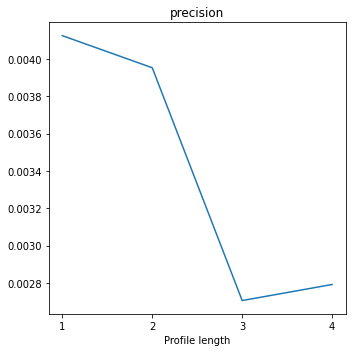

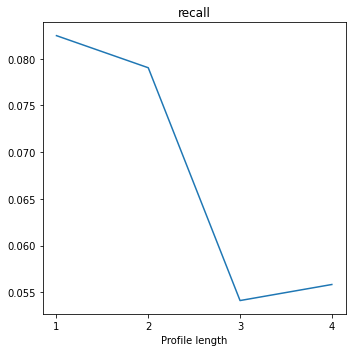

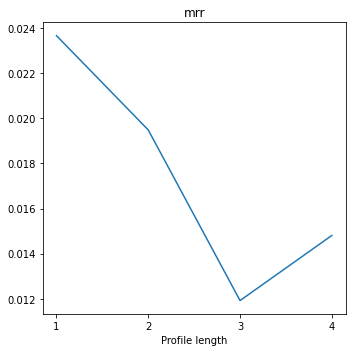

In [ ]:
evaluator.eval_profilelength()

## Scripting

### Models

In [ ]:
!mkdir -p ./src/models
!touch ./src/models/__init__.py

In [ ]:
%%writefile ./src/models/abstract.py

import logging


class ISeqRecommender(object):
    """Abstract Recommender class"""

    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger()

    def __init__(self):
        super(ISeqRecommender, self).__init__()

    def fit(self, train_data):
        pass

    def recommend(self, user_profile, user_id=None):
        """
        Given the user profile return a list of recommendation
        :param user_profile: the user profile as a list of item identifiers
        :param user_id: (optional) the user id
        :return: list of recommendations e.g. [([2], 0.875), ([6], 1.0)]
        """
        pass

    @staticmethod
    def get_recommendation_list(recommendation):
        return list(map(lambda x: x[0], recommendation))

    @staticmethod
    def get_recommendation_confidence_list(recommendation):
        return list(map(lambda x: x[1], recommendation))

    def activate_debug_print(self):
        self.logger.setLevel(logging.DEBUG)

    def deactivate_debug_print(self):
        self.logger.setLevel(logging.INFO)

Overwriting ./src/models/abstract.py


In [ ]:
%%writefile ./src/models/itempop.py

import operator

from src.models.abstract import ISeqRecommender


class PopularityRecommender(ISeqRecommender):

    def __init__(self):
        super(PopularityRecommender, self).__init__()

    def fit(self, train_data):
        sequences = train_data['sequence'].values

        count_dict = {}
        for s in sequences:
            for item in s:
                if item not in count_dict:
                    count_dict[item] = 1
                else:
                    count_dict[item] += 1

        self.top = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=True)
        self.top = [([x[0]], x[1]) for x in self.top]

    def recommend(self, user_profile, user_id=None):
        return self.top

    def get_popular_list(self):
        return self.top

Overwriting ./src/models/itempop.py


### Trainer

In [ ]:
!mkdir -p ./src/train
!touch ./src/train/__init__.py

In [ ]:
%%writefile ./src/train/itempop.py

import os
import sys
import pickle
import pandas as pd

from src.models.itempop import PopularityRecommender

data_source_path = str(sys.argv[1])
data_source_path_train = os.path.join(data_source_path, 'train.parquet.snappy')

train_data = pd.read_parquet(data_source_path_train)

pop_recommender = PopularityRecommender()

pop_recommender.fit(train_data)

pickle.dump(pop_recommender, open('./artifacts/30music/models/itempop.pkl', 'wb'))

Overwriting ./src/train/itempop.py


In [ ]:
!python ./src/train/itempop.py ./data/silver/30music

### Evaluator

In [ ]:
%%writefile ./src/eval/itempop.py

import os
import sys
import pickle
import pandas as pd

from src.eval.seqeval import SequentialEvaluator

data_source_path = str(sys.argv[1])
data_source_path_train = os.path.join(data_source_path, 'train.parquet.snappy')
data_source_path_test = os.path.join(data_source_path, 'test.parquet.snappy')

train_data = pd.read_parquet(data_source_path_train)
test_data = pd.read_parquet(data_source_path_test)

model_path = str(sys.argv[2])
model = pickle.load(open(model_path, 'rb'))

evaluator = SequentialEvaluator(train_data, test_data, model)

results = {}
results['seq_reveal'] = evaluator.eval_seqreveal()
results['static_profile'] = evaluator.eval_staticprofile()
results['rec_length'] = evaluator.eval_reclength()
results['profile_length'] = evaluator.eval_profilelength()

pickle.dump(results, open('./artifacts/30music/results/itempop.pkl', 'wb'))

Overwriting ./src/eval/itempop.py


In [ ]:
!python ./src/eval/itempop.py \
./data/silver/30music \
./artifacts/30music/models/itempop.pkl

2021-09-06 08:06:06,600 - INFO - NumExpr defaulting to 2 threads.
2891 sequences available for evaluation
100% 2891/2891 [00:00<00:00, 5767.27it/s]
2891 sequences available for evaluation
100% 2891/2891 [00:00<00:00, 21150.99it/s]
2891 sequences available for evaluation
Evaluating recommendation lists with length: 1
100% 2891/2891 [00:00<00:00, 13545.34it/s]
Evaluating recommendation lists with length: 5
100% 2891/2891 [00:00<00:00, 10330.53it/s]
Evaluating recommendation lists with length: 10
100% 2891/2891 [00:00<00:00, 8369.32it/s]
Evaluating recommendation lists with length: 20
100% 2891/2891 [00:00<00:00, 6036.25it/s]
Evaluating recommendation lists with length: 50
100% 2891/2891 [00:00<00:00, 3317.62it/s]
Evaluating recommendation lists with length: 100
100% 2891/2891 [00:01<00:00, 1886.37it/s]
1164 sequences available for evaluation
Evaluating profiles having length: 1
100% 1164/1164 [00:00<00:00, 27169.50it/s]
Evaluating profiles having length: 2
100% 1164/1164 [00:00<00:00, 25

In [ ]:
import pickle

results = pickle.load(open('./artifacts/30music/results/itempop.pkl', 'rb'))
results

{'profile_length': [[], 20, 1, 1],
 'rec_length': [[], 1, 1, 1],
 'seq_reveal': [array([0.00253285, 0.05065697, 0.01253991]), 1, 1, 1],
 'static_profile': [array([0.01267727, 0.05037537, 0.04713125]), 1, 'all', 1]}